In [1]:
from __future__ import print_function, division
import os
import numpy as np
from scipy import ndimage, misc
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from skimage import io, transform
import matplotlib.pyplot as plt
from PIL import Image
import glob
import math
from pathlib import *
import re
import random
import copy
from tqdm.notebook import tqdm, trange
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
import datetime
from PIL import Image as im
from PIL import ImageDraw, ImageFont


### 1. Dataset class definition

In these following sections, a dataset class is created for the easy handling of the Rat CT volumes, as well as their reading and transformation into suitable PyTorch dataloaders. As of now, it is hard-coded and highly dependant on the dataset shape and naming, and thus will be replaced by a file selector so that the final user can chose their own dataset, allowing to exploit the algorithm's generalization capabilities

In [2]:
class VolDset(Dataset):
    def __init__(self, path, view, transform):
        #Copy attributes of the function into self variable
        self.path_inp = path
        self.inp = os.listdir(self.path_inp)
        self.n_slices=0
        self.view=view
        self.transform=transform
        self.path=path

    def __getitem__(self, idx):
        pat=r'\d+x\d+x\d+'
        self.vol_inp = self.inp[idx]
        self.size = re.findall(pat,str(self.vol_inp))
        self.size = self.size[0].split("x")
        self.size = [int(i) for i in self.size]
        
        self.vol_inp = open(str(self.path_inp)+'\\'+self.vol_inp,'rb') #only opens the file for reading
        self.vol_inp = np.fromfile(self.vol_inp,dtype='<f4')
        self.vol_inp = self.vol_inp.reshape(self.size[0], self.size[1], self.size[2], order='F')
        
        self.param_out = self.inp[idx]
        pat=r'-*\d+\.\d+mm_du+' # pat=r'-*\d+\.\d+deg_roll+' 
        self.param_out = re.findall(pat,str(self.param_out))
        self.param_out = float(self.param_out[0][:-5]) #8
        
        self.rat_number = self.inp
        pat=r'[RAaTt_]{4,5}\d\w'
        self.rat_number = re.findall(pat,str(self.rat_number))
        self.rats = list(set(self.rat_number))
        self.rat_number = self.rats.index(self.rat_number[idx])
        
        if self.transform:
            if self.view=='axial':
                self.list_img_inp = [self.transform(self.vol_inp[:,:,i]) for i in range(self.size[2])]
            elif self.view=='coronal':
                self.list_img_inp = [self.transform(self.vol_inp[:,i,:]) for i in range(self.size[1])]
        
        return self.list_img_inp, self.param_out, self.rat_number
    
    def __len__(self):            
        return len(self.inp)

### 2. Dataset reading and transformation

In [3]:
#path_data = Path(r"C:\Users\pivot\Desktop\TFG\matlab_preproc\RECO\1.0mm_0.0deg_0.0mm")
#path_data = Path(r"E:\adri\matlab_preproc\RECO\1.0mm_0.0deg_0.0mm")
path_data = Path(r"D:\adri\matlab_preproc\RECO\1.0mm_0.0deg_0.0mm_180")

view='axial'
if view=='coronal':
    size=(512,512)#512x274
elif view=='axial':
    size=(512,512)#512x350
    
data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=3), # transforms.RandomHorizontalFlip(), transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.225])])

image_datasets_unsqueeze = VolDset(path_data,view,data_transforms)
dataset_sizes = len(image_datasets_unsqueeze)
print("The dataset contains", dataset_sizes, "volumes")

The dataset contains 150 volumes


### 3. 3D volumes to 2D images conversion, dataset and dataloader creation

Converting volumes:   0%|          | 0/150 [00:00<?, ?it/s]

Dataset succesfully converted
Training images:   25000
Validation images: 5000
Train/validation distribution: ['train', 'train', 'train', 'train', 'train', 'val']


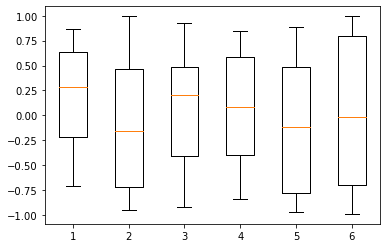

Data bound between -0.9911999702453613 and 0.9951000213623047
Image size = torch.Size([3, 256, 256])

Example image shown below:


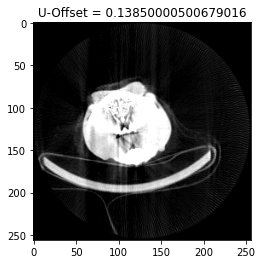

In [4]:
#image_datasets=dict()
#stats_datasets=dict()
x_tr=[]
y_tr=[]
x_val=[]
y_val=[]

# We set 5/7 rats to be our training dataset and 2/7 to be our validation dataset
train_or_val = ['train']*5 + ['val']*1
#random.shuffle(train_or_val)

# We can divide our dataset by this amount if we lack memory
dataset_red = 1;

# We split our volumes into slices and pack them together
temp_error = [[] for _ in range(len(train_or_val))]

with tqdm(total=int(dataset_sizes/dataset_red), leave = False, desc='Converting volumes') as pbar:
    for i in range(int(dataset_sizes/dataset_red)):
        inp,lbl,rat=image_datasets_unsqueeze[dataset_red*i]
        pbar.update(1)
        temp_error[rat] += [lbl] # if lbl > 0:
        for j in range(len(inp)):
            #image_datasets.setdefault(x, [])
            if train_or_val[rat]=='train':
                x_tr.append(inp[j])
                y_tr.append(lbl) # abs(lbl)
            elif train_or_val[rat]=='val':
                x_val.append(inp[j])
                y_val.append(lbl) # abs(lbl)
            #image_datasets[x].append((Image(inp[j]),Image(lbl[j])))
print("Dataset succesfully converted")

train_dset=list(zip(x_tr,torch.Tensor(y_tr).float()))
valid_dset=list(zip(x_val,torch.Tensor(y_val).float()))

# Now we print some statistics and examples
print("Training images:  ", len(train_dset))
print("Validation images:", len(valid_dset))
print("Train/validation distribution:", train_or_val)
plt.boxplot(temp_error)
plt.show()
del temp_error

# We check the maximum and minimum values of our u-offset
data_min = 1000
data_max = -1000
for slice in train_dset + valid_dset:
    if slice[1] < data_min:
        data_min = slice[1]
    elif slice[1] > data_max:
        data_max = slice[1]
print("Data bound between", float(data_min.data), "and", float(data_max.data))

x,y=train_dset[300]
input_size = x.data.size()
print("Image size =", input_size)
print("")
print("Example image shown below:")
plt.imshow(x.data[1,:,:].T, cmap='gray')
plt.title('U-Offset = ' + str(y.item()))

# Lastly we create the DataLoaders from the DataSets specifying batch_size and shuffle
val_loader = DataLoader(valid_dset, batch_size=16, shuffle=False) #, **kwargs)
train_loader = DataLoader(train_dset, batch_size=16, shuffle=False) #, **kwargs)

# We now get rid of the variables we will not be using anymore
del inp, lbl, rat, image_datasets_unsqueeze, x_tr, y_tr, x_val, y_val, x, y

### Optional 1. Find optimal learning rate for our model

In this section, the Learning Rate Finder library is employed on the given model to check the perfect bounds for the Cyclical Learning Rate. It has been used to test the optimal LR on transfer learning models as well as in randomly generated models to study the dependance of the optimal LR with their architecture.

In [ ]:
from torch_lr_finder import LRFinder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU available:", device == torch.device('cuda'))

model = torch.hub.load('pytorch/vision:v0.10.0', "alexnet", pretrained=True)

#model.features = nn.Sequential(*list(model.features.children())[:2])
#model.avgpool = nn.AdaptiveAvgPool2d([10, 10])

#output_size = [0, model.avgpool.output_size[0], model.avgpool.output_size[1]]
#index = len(model.features)
#while output_size[0] == 0:
#    index -= 1
#    if type(model.features[index]) == torch.nn.modules.conv.Conv2d:
#        output_size[0] = model.features[index].out_channels

#features = 1
#for dim in output_size:
#    features = features*dim

#model.classifier = nn.Sequential(nn.Linear(in_features=int(features), out_features=500, bias=True),
#                                         torch.nn.modules.activation.ReLU(inplace = True),
#                                         torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
#                                         nn.Linear(in_features=500, out_features=500, bias=True),
#                                         torch.nn.modules.activation.ReLU(inplace = True),
#                                         torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
#                                         nn.Linear(in_features=500, out_features=1, bias=True))

model.classifier = nn.Sequential(*list(model.classifier.children()), nn.ReLU(), nn.Linear(1000, 1))

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-10)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1e-0, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
del lr_finder

### 4. Definition of the output sigmoid, the food source and different bees' classes

All of the functions and classes used in the Chimera Algorithm itself are defined right below. As for the previous sections, some things are hard-coded —as, per instance, the fact that the algorithm only deals with regression problems with 1 output— to deal with the CT artifact identification problem, and thus need to be standardized and generalized. 

In [6]:
def free_gpu_cache(show_usage = False):
# This function is used to clear the GPU cache and avoid memory problems when dealing with large populations and big models
    if show_usage:
        print("Initial GPU Usage")
        gpu_usage()
    gc.collect()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    if show_usage:
        print("GPU Usage after emptying the cache")
        gpu_usage()
        print("GPU available:", device == torch.device('cuda'))


class outputSigmoid(nn.Module): 
# This can be used as the final layer of the models, bounded between the max and min values of our dataset  
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return torch.sigmoid(input) * (data_max - data_min) / 2 + (data_max + data_min) / 2


class modified_MAE(nn.Module):
# A custom loss function can be created for the specific problem at hand —although it has been deprecated for now
    def __init__(self):
        super(modified_MAE, self).__init__()

    def forward(self, lab, out):        
        #lab = lab.to("cpu") # We retrieve our labels and outputs
        #out = out.to("cpu")
        loss = torch.mean(torch.abs(lab-out)) # Calculate the Mean Absolute Error

        for unique_lab in lab : # And then for each label we add a term based of the std of the outputs that should be the same
            loss += (0.2 / len(lab)) * torch.std(out[[coinc for coinc, val in enumerate([current_label == unique_lab for current_label in lab]) if val]])
        return loss


# We select the desired loss function
criterion = nn.L1Loss() # = modified_MAE() # = nn.MSELoss()


class Stats:
# This class holds all the variables of interest for the inspection of the evolution of both mean and best models
    def __init__(self):
        self.frames = []
        self.train_loss_evolution_best = []
        self.val_loss_evolution_best = []
        self.conv_layers_evolution_best = []
        self.avg_pool_layers_evolution_best = []
        self.max_pool_layers_evolution_best = []
        self.mean_conv_kernel_width_evolution_best = []
        self.mean_conv_kernel_heigth_evolution_best = []
        self.mean_pool_kernel_size_evolution_best = []
        self.mean_conv_stride_width_evolution_best = []
        self.mean_conv_stride_heigth_evolution_best = []
        self.mean_pool_stride_size_evolution_best = []
        self.mean_num_features_evolution_best = []
        self.num_parameters_evolution_best = []
        
        self.train_loss_evolution_mean = []
        self.val_loss_evolution_mean = []
        self.conv_layers_evolution_mean = []
        self.avg_pool_layers_evolution_mean = []
        self.max_pool_layers_evolution_mean = []
        self.mean_conv_kernel_width_evolution_mean = []
        self.mean_conv_kernel_heigth_evolution_mean = []
        self.mean_pool_kernel_size_evolution_mean = []
        self.mean_conv_stride_width_evolution_mean = []
        self.mean_conv_stride_heigth_evolution_mean = []
        self.mean_pool_stride_size_evolution_mean = []
        self.mean_num_features_evolution_mean = []
        self.num_parameters_evolution_mean = []
        
    def update(self, bees, ex_ffss):
        best_loss = 10000
        total_loss = 0
        total_conv_layers = 0
        total_avg_layers = 0
        total_max_layers = 0
        total_num_param = 0
        total_conv_kernel_width = 0
        total_conv_kernel_height = 0
        total_pool_kernel_size = 0
        total_conv_stride_width = 0
        total_conv_stride_height = 0
        total_pool_stride_size = 0
        total_num_features = 0
        total_val_loss = 0
        total_train_loss = 0
        for fs in [bee.fs for bee in bees[0:Np]] + ex_ffss:
            if np.mean(fs.val_loss_ev[-4:]) < best_loss:
                best_loss = copy.deepcopy(np.mean(fs.val_loss_ev[-4:]))
                best_fs = copy.deepcopy(fs)
                self.best_model = copy.deepcopy(best_fs.food)
            
            for l in list(fs.food.features.children()):
                conv_layers = 0
                avg_pool_layers = 0
                avg_pool_layers = 0
                conv_kernel_width = 0
                conv_kernel_height = 0
                conv_stride_width = 0
                conv_stride_height = 0
                num_features = 0
                max_pool_layers = 0
                pool_kernel_size = 0
                pool_stride_size = 0
                if type(l) == torch.nn.modules.conv.Conv2d:
                    conv_layers += 1
                    conv_kernel_width += l.kernel_size[1]
                    conv_kernel_height += l.kernel_size[0]
                    conv_stride_width += l.stride[1]
                    conv_stride_height += l.stride[0]
                    num_features += l.out_channels
                
                elif type(l) == torch.nn.modules.pooling.MaxPool2d:
                    max_pool_layers += 1
                    pool_kernel_size += l.kernel_size
                    pool_stride_size += l.stride
                elif type(l) == torch.nn.modules.pooling.AvgPool2d:
                    avg_pool_layers += 1
                    pool_kernel_size += l.kernel_size
                    pool_stride_size += l.stride
            
                total_conv_layers += conv_layers
                total_avg_layers += avg_pool_layers
                total_max_layers += max_pool_layers
                
            if conv_layers == 0:
                total_conv_kernel_width += 0
                total_conv_kernel_height += 0
                total_conv_stride_width += 0
                total_conv_stride_height += 0
                total_num_features += 0
            else:
                total_conv_kernel_width += conv_kernel_width/conv_layers
                total_conv_kernel_height += conv_kernel_height/conv_layers
                total_conv_stride_width += conv_stride_width/conv_layers
                total_conv_stride_height += conv_stride_height/conv_layers
                total_num_features += num_features/conv_layers
            if max_pool_layers + avg_pool_layers == 0:
                total_pool_kernel_size += 0
                total_pool_stride_size += 0
            else:
                total_pool_kernel_size += pool_kernel_size/(max_pool_layers + avg_pool_layers)
                total_pool_stride_size += pool_stride_size/(max_pool_layers + avg_pool_layers)
                
            total_val_loss += copy.deepcopy(np.mean(fs.val_loss_ev[-4:]))
            total_train_loss += copy.deepcopy(np.mean(fs.train_loss_ev[-4:]))
            total_num_param += sum (p.numel () for p in fs.food.parameters ())

        self.train_loss_evolution_mean += [total_train_loss/(Np+len(ex_ffss))]
        self.val_loss_evolution_mean += [total_val_loss/(Np+len(ex_ffss))]
        self.conv_layers_evolution_mean += [total_conv_layers/(Np+len(ex_ffss))]
        self.avg_pool_layers_evolution_mean += [total_avg_layers/(Np+len(ex_ffss))]
        self.max_pool_layers_evolution_mean += [total_max_layers/(Np+len(ex_ffss))]
        self.mean_conv_kernel_width_evolution_mean += [total_conv_kernel_width/(Np+len(ex_ffss))]
        self.mean_conv_kernel_heigth_evolution_mean += [total_conv_kernel_height/(Np+len(ex_ffss))]
        self.mean_pool_kernel_size_evolution_mean += [total_pool_kernel_size/(Np+len(ex_ffss))]
        self.mean_conv_stride_width_evolution_mean += [total_conv_stride_width/(Np+len(ex_ffss))]
        self.mean_conv_stride_heigth_evolution_mean += [total_conv_stride_height/(Np+len(ex_ffss))]
        self.mean_pool_stride_size_evolution_mean += [total_pool_stride_size/(Np+len(ex_ffss))]
        self.mean_num_features_evolution_mean += [total_num_features/(Np+len(ex_ffss))]
        self.num_parameters_evolution_mean += [total_num_param/(Np+len(ex_ffss))]
        
        conv_layers = 0
        avg_pool_layers = 0
        avg_pool_layers = 0
        conv_kernel_width = 0
        conv_kernel_height = 0
        conv_stride_width = 0
        conv_stride_height = 0
        num_features = 0
        max_pool_layers = 0
        pool_kernel_size = 0
        pool_stride_size = 0
        for l in list(best_fs.food.features.children()):
            if type(l) == torch.nn.modules.conv.Conv2d:
                conv_layers += 1
                conv_kernel_width += l.kernel_size[1]
                conv_kernel_height += l.kernel_size[0]
                conv_stride_width += l.stride[1]
                conv_stride_height += l.stride[0]
                num_features += l.out_channels

            elif type(l) == torch.nn.modules.pooling.MaxPool2d:
                max_pool_layers += 1
                pool_kernel_size += l.kernel_size
                pool_stride_size += l.stride
            elif type(l) == torch.nn.modules.pooling.AvgPool2d:
                avg_pool_layers += 1
                pool_kernel_size += l.kernel_size
                pool_stride_size += l.stride
        
        self.train_loss_evolution_best += [copy.deepcopy(np.mean(best_fs.train_loss_ev[-4:]))]
        self.val_loss_evolution_best += [copy.deepcopy(np.mean(best_fs.val_loss_ev[-4:]))]
        self.conv_layers_evolution_best += [conv_layers]
        self.avg_pool_layers_evolution_best += [avg_pool_layers]
        self.max_pool_layers_evolution_best += [max_pool_layers]
        if conv_layers == 0:
            self.mean_conv_kernel_width_evolution_best += [0]
            self.mean_conv_kernel_heigth_evolution_best += [0]
            self.mean_conv_stride_width_evolution_best += [0]
            self.mean_conv_stride_heigth_evolution_best += [0]
            self.mean_num_features_evolution_best += [0]
        else:
            self.mean_conv_kernel_width_evolution_best += [conv_kernel_width/conv_layers]
            self.mean_conv_kernel_heigth_evolution_best += [conv_kernel_height/conv_layers]
            self.mean_conv_stride_width_evolution_best += [conv_stride_width/conv_layers]
            self.mean_conv_stride_heigth_evolution_best += [conv_stride_height/conv_layers]
            self.mean_num_features_evolution_best += [num_features/conv_layers]
        if max_pool_layers + avg_pool_layers == 0:
            self.mean_pool_kernel_size_evolution_best += [0]
            self.mean_pool_stride_size_evolution_best += [0]
        else:
            self.mean_pool_kernel_size_evolution_best += [pool_kernel_size/(max_pool_layers + avg_pool_layers)]
            self.mean_pool_stride_size_evolution_best += [pool_stride_size/(max_pool_layers + avg_pool_layers)]
        self.num_parameters_evolution_best += [sum (p.numel () for p in best_fs.food.parameters ())]
    
    def show_stats(self):
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_evolution_best)
        plt.plot(self.val_loss_evolution_best)
        plt.legend(["Training loss", "Validation loss"])
        plt.title("Best model's loss evolution")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.train_loss_evolution_mean)
        plt.plot(self.val_loss_evolution_mean)
        plt.legend(["Training loss", "Validation loss"])
        plt.title("Mean model's loss evolution")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.conv_layers_evolution_best)
        plt.plot(self.avg_pool_layers_evolution_best)
        plt.plot(self.max_pool_layers_evolution_best)
        plt.legend(["Convolutional layers", "Avg pool layers", "Max pool layers"])
        plt.title("Best model's number of layers")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.conv_layers_evolution_mean)
        plt.plot(self.avg_pool_layers_evolution_mean)
        plt.plot(self.max_pool_layers_evolution_mean)
        plt.legend(["Convolutional layers", "Avg pool layers", "Max pool layers"])
        plt.title("Mean model's number of layers")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_conv_kernel_width_evolution_best)
        plt.plot(self.mean_conv_kernel_heigth_evolution_best)
        plt.plot(self.mean_pool_kernel_size_evolution_best)
        plt.legend(["Conv mean kernel width", "Conv mean kernel height", "Pool mean kernel size"])
        plt.title("Best model's mean kernel sizes")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.mean_conv_kernel_width_evolution_mean)
        plt.plot(self.mean_conv_kernel_heigth_evolution_mean)
        plt.plot(self.mean_pool_kernel_size_evolution_mean)
        plt.legend(["Conv mean kernel width", "Conv mean kernel height", "Pool mean kernel size"])
        plt.title("Mean model's mean kernel sizes")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_conv_stride_width_evolution_best)
        plt.plot(self.mean_conv_stride_heigth_evolution_best)
        plt.plot(self.mean_pool_stride_size_evolution_best)
        plt.legend(["Conv mean stride width", "Conv mean stride height", "Pool mean stride size"])
        plt.title("Best model's mean stride sizes")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.mean_conv_stride_width_evolution_mean)
        plt.plot(self.mean_conv_stride_heigth_evolution_mean)
        plt.plot(self.mean_pool_stride_size_evolution_mean)
        plt.legend(["Conv mean stride width", "Conv mean stride height", "Pool mean stride size"])
        plt.title("Mean model's mean stride sizes")
        plt.show()
        
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_num_features_evolution_best)
        plt.plot(self.mean_num_features_evolution_mean)
        plt.legend(["Best model", "Mean model"])
        plt.title("Mean number of feature maps")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.num_parameters_evolution_best)
        plt.plot(self.num_parameters_evolution_mean)
        plt.legend(["Best model", "Mean model"])
        plt.title("Number of parameters")
        plt.show()
    
    def show_best_model(self):
    # This function checks the performance of the algorithm on the validation dataset and display the statistics of interest
        free_gpu_cache()
        self.best_model.to(device)

        all_labels = torch.empty(0)
        results = torch.empty(0)
        with tqdm(total=len(val_loader)*16-16, leave = False, desc = "Obtaining the results on validation dataset") as pbar:
            with torch.no_grad():
                for data in val_loader:
                    features, labels = data
                    all_labels = torch.cat((all_labels, labels), 0)
                    features = features.to(device)
                    vi = self.best_model(features).squeeze().to("cpu")
                    results = torch.cat((results, vi), 0)
                    pbar.update(labels.size(0))

        unique_labels = all_labels.unique()
        split_results = [[] for _ in range(len(unique_labels))]
        for unique_index in range(len(unique_labels)):
            for index in range(len(results)):
                if all_labels[index] == unique_labels[unique_index]:
                    split_results[unique_index] += [float(results[index])]
    
        print(self.best_model)
        plt.boxplot(split_results)
        plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], unique_labels, 'rx')
        plt.title("Best model's predictions (box plots) and label values (red xs)")
        plt.ylim([-1.1, 1.1])
        plt.show()

        del all_labels, results, data, features, labels, vi, pbar, unique_labels, split_results, unique_index, index
        self.best_model.to("cpu")
        free_gpu_cache()
    
    def draw_frame(self):
    # This function creates a frame with a visualization of the best model, along with its statistics,
    # to use in the creation of a GIF showing the evolution throughout the iterations of the Chimera Algorithm
    
        array = np.ones((1080, 1920, 3), np.uint8)*255
        x = 1600
        d = 10
        w = 100
        h = 20

        for ii in range(-d,d):
            array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 200
            array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 235
            array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 30

            array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 0] = 180
            array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 1] = 215
            array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 2] = 0

        array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 200
        array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 255
        array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 0
        x -= w

        data = im.fromarray(array)
        draw_data = ImageDraw.Draw(data)
        draw_data.text((x+ii+12, 495), "Predictor", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 20))
        array = np.array(data)

        l1 = 0
        array[498:502, x-25:x, :] = 0
        if type(self.best_model.features[-1]) == torch.nn.modules.activation.ReLU:
            array[498:502, x-25:x, 0] = 200
            l1 = 1
        x -= 25

        for l in range(l1, len(self.best_model.features)):
            i = len(self.best_model.features) - l - 1
            layer = self.best_model.features[i]

            if i < len(self.best_model.features)-1:
                if type(self.best_model.features[i+1]) == torch.nn.modules.activation.ReLU:
                    array[498:502, x-30:x, :] = 0
                    array[498:502, x-30:x, 0] = 200
                    x -= 30
                elif type(layer) != torch.nn.modules.activation.ReLU:
                    array[498:502, x-30:x, :] = 0
                    x -= 30

            if type(layer) == torch.nn.modules.conv.Conv2d:
                d = max([int(layer.out_channels*0.25),1])
                w = layer.kernel_size[1]*10
                h = layer.kernel_size[0]*5

                for ii in range(-d,d):
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 0
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 200
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 255

                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 0] = 50
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 1] = 150
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 2] = 255

                array[500-h+ii:500+h+ii, x-w+d:x+ii, 0] = 0
                array[500-h+ii:500+h+ii, x-w+d:x+ii, 1] = 255
                array[500-h+ii:500+h+ii, x-w+d:x+ii, 2] = 255
                x -= w
                
                for iii in range(ii, 250):
                    array[500+iii, x+iii+int(w/2), :] = 0
                data = im.fromarray(array)
                draw_data = ImageDraw.Draw(data)
                draw_data.text((x+iii+13, 510+iii), "Conv", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 16))
                draw_data.text((x+iii+13, 530+iii), str(layer.kernel_size[0])+"x"+str(layer.kernel_size[1])+"x"+str(layer.out_channels), fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 9))
                array = np.array(data)

            elif type(layer) == torch.nn.modules.pooling.MaxPool2d:
                while type(self.best_model.features[i]) != torch.nn.modules.conv.Conv2d:
                    i -= 1
                if i >= 0:
                    d = int(self.best_model.features[i].out_channels*0.25)
                else:
                    d = 1
                w = layer.kernel_size*10
                h = layer.kernel_size*5

                for ii in range(-d,d):
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 225
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 30
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 255

                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 0] = 200
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 1] = 0
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 2] = 255

                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 255
                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 0
                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 255
                x -= w

                for iii in range(ii, 250):
                    array[500+iii, x+iii+int(w/2), :] = 0
                data = im.fromarray(array)
                draw_data = ImageDraw.Draw(data)
                draw_data.text((x+iii+13, 510+iii), "Max", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 16))
                draw_data.text((x+iii+13, 530+iii), str(layer.kernel_size)+"x"+str(layer.kernel_size), fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 9))
                array = np.array(data)
            
            elif type(layer) == torch.nn.modules.pooling.AvgPool2d:
                while type(self.best_model.features[i]) != torch.nn.modules.conv.Conv2d:
                    i -= 1
                if i >= 0:
                    d = int(self.best_model.features[i].out_channels*0.25)
                else:
                    d = 1
                w = layer.kernel_size*10
                h = layer.kernel_size*5

                for ii in range(-d,d):
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 175
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 145
                    array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 50

                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 0] = 155
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 1] = 125
                    array[500-h+ii:500+h+ii, x-w+ii:x-w+1+ii, 2] = 50

                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 0] = 255
                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 1] = 155
                array[500-h+ii:500+h+ii, x-w+ii:x+ii, 2] = 50
                x -= w
                
                for iii in range(ii, 250):
                    array[500+iii, x+iii+int(w/2), :] = 0
                data = im.fromarray(array)
                draw_data = ImageDraw.Draw(data)
                draw_data.text((x+iii+13, 510+iii), "Avg", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 16))
                draw_data.text((x+iii+13, 530+iii), str(layer.kernel_size)+"x"+str(layer.kernel_size), fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 9))
                array = np.array(data)

        # Creating image object out of the numpy array
        array[180:180+self.ev_plot.shape[0],:self.ev_plot.shape[1],:] = self.ev_plot 
        array[self.ev_plot.shape[0]+230:self.ev_plot.shape[0]+230+self.box_plot.shape[0],:self.box_plot.shape[1],:] = self.box_plot
        
        array[53:73, 420:440, 0] = 0 #conv
        
        array[53:73, 670:690, 1] = 0 #max
        
        array[53:73, 920:940, 0] = 255 #avg
        array[53:73, 920:940, 1] = 155
        array[53:73, 920:940, 2] = 50
        
        array[53:73, 1170:1190, :] = 0 #direct
        
        array[53:73, 1420:1440, :] = 0 #ReLU
        array[53:73, 1420:1440, 0] = 200
        
        data = im.fromarray(array)
        draw_im = ImageDraw.Draw(data)
        draw_im.text((70, 36), "ITERATION "+str(len(self.frames)), fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 42))
        draw_im.text((53, 170), "PERFORMANCE EVOLUTION", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 24))
        draw_im.text((93, 510), "CURRENT BEHAVIOR", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 24))
        
        draw_im.text((450, 50), "Convolutional layer", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 22))
        draw_im.text((700, 50), "Max Pooling layer", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 22))
        draw_im.text((950, 50), "Avg Pooling layer", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 22))
        draw_im.text((1200, 50), "Direct connection", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 22))
        draw_im.text((1450, 50), "ReLU connection", fill=(0, 0, 0), font = ImageFont.truetype("arial.ttf", 22))
        
        self.frames += [copy.deepcopy(data)]
    
    def show_last_frame(self):
    # Show last frame
        self.frames[-1].show()
        
    def save_gif(self):
    # Save the whole visualization as a GIF file
        self.frames[0].save('model_ev_visual.gif', save_all=True, append_images=self.frames[1:], optimize=False, duration=750, loop=0)
        
    def get_plots(self):
    # This function retrieves the plots of interest as numpy arrays to paste them onto the pertinent frame
        free_gpu_cache()
        self.best_model.to(device)

        all_labels = torch.empty(0)
        results = torch.empty(0)
        with tqdm(total=len(val_loader)*16-16, leave = False, desc = "Obtaining the results on validation dataset") as pbar:
            with torch.no_grad():
                for data in val_loader:
                    features, labels = data
                    all_labels = torch.cat((all_labels, labels), 0)
                    features = features.to(device)
                    vi = self.best_model(features).squeeze().to("cpu")
                    results = torch.cat((results, vi), 0)
                    pbar.update(labels.size(0))

        unique_labels = all_labels.unique()
        split_results = [[] for _ in range(len(unique_labels))]
        for unique_index in range(len(unique_labels)):
            for index in range(len(results)):
                if all_labels[index] == unique_labels[unique_index]:
                    split_results[unique_index] += [float(results[index])]

        fig = plt.figure()
        plt.ion()
        plt.boxplot(split_results)
        plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], unique_labels, 'rx')
        plt.ylim([-1.1, 1.1])
        plt.ylabel("OFFSET VALUE")
        fig.canvas.draw()

        # Now we can save it to a numpy array.
        self.box_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        self.box_plot = self.box_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        fig = plt.figure()
        plt.ion()
        plt.plot(self.train_loss_evolution_best)
        plt.plot(self.val_loss_evolution_best)
        plt.legend(["Training loss", "Validation loss"])
        plt.xlabel("ITERATION")
        plt.ylabel("LOSSES")
        fig.canvas.draw()

        # Now we can save it to a numpy array.
        self.ev_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        self.ev_plot = self.ev_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        del all_labels, results, data, features, labels, vi, pbar, unique_labels, split_results, unique_index, index
        self.best_model.to("cpu")
        free_gpu_cache()
        
    

class FoodSource:
# The food sources will hold the models and represent the position in the hyperspace where the algorithm's agents are
    def __init__(self, net, fs_exhaustion_limit):
        self.food = net # The food source's core is the model to be improved
        self.fs_exhaustion_limit = fs_exhaustion_limit # Number of times a food source can be exploited before considering it exhausted (local minimum)
        self.fs_exhaustion = 0
        self.cyclelength = 4 # Number of epochs to go from the smallest to the largest learning rate
        self.stepsize = 4 * self.cyclelength * len(train_loader) # According to L.N.Smith, sz = 2-10 times the epoch length
        self.lrs = np.concatenate([np.linspace(5e-6, 5e-5, num = self.stepsize, endpoint = False), np.linspace(5e-5, 5e-6, num = self.stepsize, endpoint = False)])
        self.moms = np.concatenate([np.linspace(0.95, 0.85, num = self.stepsize, endpoint = False), np.linspace(0.85, 0.95, num = self.stepsize, endpoint = False)])
        self.t_epochs = 8 * self.cyclelength # Max epochs to be trained, unless the model starts overfitting
        #self.optimizer = optim.SGD(self.food.parameters(), self.lrs[0], self.moms[0])
        self.optimizer = optim.Adam(self.food.parameters(), self.lrs[0])
        self.nectar = 0
        self.nectar_ev = [0]
        self.train_loss_ev = [0]
        self.val_loss_ev = [0]

    def mutate_feature_extractor(self, mut_amount, print_change = False):
    # This function takes a model and mutates its layer as to obtain a distinct but similar one
        deprecated = True
        max_layers = 25

        while deprecated:
            # The amount of mutations is random but increases as the source becomes exhausted
            #mut_amount = int(abs(np.random.normal(loc=1.0, scale=(1+self.fs_exhaustion)**1/3))+1)
            if print_change:
                print("Mutating the model", mut_amount, "times")
            for m in range(mut_amount):
                model_mutated = copy.deepcopy(self.food)
                mut_type = random.choices(["add", "mut", "del", "res"], weights = [20, 15, 5, 5])[0] #"cav", "clr",
                features = 0
                if mut_type == "add" and len(model_mutated.features) < max_layers:
                    self.add_layer(model_mutated)
                    features = 1
                elif mut_type == "mut":
                    self.mut_layer(model_mutated)
                    features = 1
                elif mut_type == "del" and len(model_mutated.features) > 2:
                    self.del_layer(model_mutated)
                    features = 1
                elif mut_type == "cav":
                    self.change_avg_pool(model_mutated)
                    features = 1
                elif mut_type == "res":
                    self.reset_weights(model_mutated)
                    features = 1
                elif mut_type == "clr":
                    self.change_lr()
            
            self.prune_model(model_mutated)
            
            output_size = [0, model_mutated.avgpool.output_size[0], model_mutated.avgpool.output_size[1]]
            index = len(model_mutated.features)
            while output_size[0] == 0 and index > 0:
                index -= 1
                if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                    output_size[0] = model_mutated.features[index].out_channels
            
            for dim in output_size:
                features = features*dim

            if features > 0:
                deprecated = False
            elif print_change:
                print("Invalid mutation. Retrying process.")

        model_mutated.classifier = nn.Sequential(torch.nn.modules.activation.ReLU(inplace = True),
                                                 nn.Linear(in_features=int(features), out_features=500, bias=True),
                                                 torch.nn.modules.activation.ReLU(inplace = True),
                                                 torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                                 nn.Linear(in_features=500, out_features=500, bias=True),
                                                 torch.nn.modules.activation.ReLU(inplace = True),
                                                 torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                                 nn.Linear(in_features=500, out_features=1, bias=True))
        self.food = copy.deepcopy(model_mutated)

    def prune_model(self, model_mutated, print_change = False):
    # This function makes sure that the model layers do not prasent incongruent patterns
        if print_change:
            print("Pruning model")
        
        index = 1
        condition = True
        while condition:
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
                cl = "conv"
            elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
                cl = "pool"
            elif type(model_mutated.features[index]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index]) == torch.nn.Tanh or type(model_mutated.features[index]) == torch.nn.Sigmoid:
                cl = "act_fun"
            if type(model_mutated.features[index-1]) == torch.nn.modules.conv.Conv2d:
                pl = "conv"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index-1]) == torch.nn.modules.pooling.AvgPool2d:
                pl = "pool"
            elif type(model_mutated.features[index-1]) == torch.nn.modules.activation.ReLU or type(model_mutated.features[index-1]) == torch.nn.Tanh or type(model_mutated.features[index-1]) == torch.nn.Sigmoid:
                pl = "act_fun"
            
            if pl == "conv" and cl == "conv": # We add a ReLU between two consecutive conv layers
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], torch.nn.modules.activation.ReLU(inplace = True), *list(model_mutated.features.children())[index:])
                index = 0
            elif pl == "act_fun" and cl == "pool": # If an act function precedes a pooling layer, they are switched 
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], model_mutated.features[index], model_mutated.features[index-1], *list(model_mutated.features.children())[index+1:])
                index = 0
            elif pl == cl: # If two layers are the same (but not conv), the first one is removed
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index-1], *list(model_mutated.features.children())[index:])
                index = 0
            index += 1
            condition = index < len(model_mutated.features)
    
    def change_lr(self, print_change = False):
        new_lr_min = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6])
        new_lr_range = random.choice([5, 10, 20])
        self.lrs = np.concatenate([np.linspace(new_lr_min, new_lr_min*new_lr_range, num = self.stepsize, endpoint = False), np.linspace(new_lr_min*new_lr_range, new_lr_min, num = self.stepsize, endpoint = False)])
        if print_change:
            print("Learning rate updated.")
    
    def change_avg_pool(self, model_mutated , print_change = False):
        max_out_size = 50
        model_mutated.avgpool = nn.AdaptiveAvgPool2d([random.randint(1, max_out_size), random.randint(1, max_out_size)])
        
    def add_layer(self, model_mutated, print_change = False):
        max_k_size = 5

        cw = 1
        pw = 1
        afw = 1
        for layer in model_mutated.features:
            if type(layer) == torch.nn.modules.conv.Conv2d:
                cw += 1
            elif type(layer) == torch.nn.modules.pooling.MaxPool2d or type(layer) == torch.nn.modules.pooling.AvgPool2d:
                pw += 1
            elif type(layer) == torch.nn.ReLU() or type(layer) == torch.nn.Tanh() or type(layer) == torch.nn.Sigmoid():
                afw += 1
        layer_type = random.choices(["conv", "pool"], weights = [4/cw, 1/pw], k = 1)[0] # , "act_fun", 1/afw
        index = random.randint(1, len(model_mutated.features))

        if print_change:
            print("Inserting", layer_type, "at layer", index)
        if layer_type == "pool":
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                new_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                new_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)

        elif layer_type == "act_fun":
            new_layer = nn.ReLU()

        elif layer_type == "conv":
            dim = 0 # The inserted convolutional layer will have the same input feature maps as output ones as to fit within
            index_search = index
            while dim == 0:
                index_search -= 1
                if index_search < 0:
                    dim = 1
                    break
                if type(model_mutated.features[index_search]) == torch.nn.modules.conv.Conv2d:
                    dim = model_mutated.features[index_search].out_channels
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            new_layer = nn.Conv2d(dim, dim, kernel_size=k_size, stride=st, padding=pad)

        model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], new_layer, *list(model_mutated.features.children())[index:])

    def mut_layer(self, model_mutated, print_change = False):
        max_k_size = 5
        f_size_variab = 2

        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Mutating layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            dim_out = max(1, random.randint(int(model_mutated.features[index].out_channels/f_size_variab), min(int(model_mutated.features[index].out_channels*f_size_variab), 512)))
            k_size = (random.randint(1, max_k_size), random.randint(1, max_k_size))
            st = (random.randint(1, k_size[0]), random.randint(1, k_size[1]))
            pad = (random.randint(0, int(k_size[0]/2)), random.randint(0, int(k_size[1]/2)))
            mut_layer = nn.Conv2d(dim_in, dim_out, kernel_size=k_size, stride=st, padding=pad)
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_out, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index+1:])

        elif type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            pool_type = random.choice(["max", "avg"])
            k_size = random.randint(2, max_k_size)
            st = random.randint(1, k_size)
            if pool_type == "max":
                mut_layer = nn.MaxPool2d(kernel_size=k_size, stride=st, padding=0)
            elif pool_type == "avg":
                mut_layer = nn.AvgPool2d(kernel_size=k_size, stride=st, padding=0)
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid:
            mut_layer = nn.ReLU()
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], mut_layer, *list(model_mutated.features.children())[index_end:])

    def del_layer(self, model_mutated, print_change = False):
        index = random.randint(0, len(model_mutated.features)-1)
        index_end = index+1
        if print_change:
            print("Deleting layer", index)

        if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d:
            dim_in = model_mutated.features[index].in_channels
            while index_end < len(model_mutated.features) and type(model_mutated.features[index_end]) != torch.nn.modules.conv.Conv2d:
                index_end += 1
            if index_end < len(model_mutated.features):
                fixed_layer = nn.Conv2d(dim_in, model_mutated.features[index_end].out_channels, kernel_size=model_mutated.features[index_end].kernel_size, stride=model_mutated.features[index_end].stride, padding=model_mutated.features[index_end].padding)
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:index_end], fixed_layer, *list(model_mutated.features.children())[index_end+1:])
            else:
                model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index+1:])

        # If it is a pooling or activation function layer we get rid of it directly
        elif type(model_mutated.features[index]) == torch.nn.modules.ReLU or type(model_mutated.features[index]) == torch.nn.modules.Tanh or type(model_mutated.features[index]) == torch.nn.modules.Sigmoid or type(model_mutated.features[index]) == torch.nn.modules.pooling.MaxPool2d or type(model_mutated.features[index]) == torch.nn.modules.pooling.AvgPool2d:
            model_mutated.features = nn.Sequential(*list(model_mutated.features.children())[:index], *list(model_mutated.features.children())[index_end:])

    def reset_weights(self, model_mutated, print_change = False): # Reinitialize the predictor's weights
        reset_prob = 0.7
        reseted_layers = []
        for index in range(len(model_mutated.features)):
            if type(model_mutated.features[index]) == torch.nn.modules.conv.Conv2d and random.random() < reset_prob:
                reseted_layers += [index]
                nn.init.xavier_uniform_(model_mutated.features[index].weight.data, gain=nn.init.calculate_gain('relu'))
        if print_change:
            print("Weights reseted on layers", reseted_layers)
    
    def train_fs(self):
    # This function is used to train the model for a certain number of epochs
        self.food.to(device)
        loss_tra = []
        loss_val = []
        nectar_ev = []
        overfit = 0
        lr_index = 0
        invalid = False
        with tqdm(total=self.t_epochs, leave = False, desc='Training') as pbar1:
            for epoch in range(self.t_epochs): # loop over the dataset multiple times
                running_loss = 0.0
                with tqdm(total=len(train_loader), leave = False, desc='Epoch progress') as pbar2:
                    for i, data in enumerate(train_loader, 0):
                        if lr_index >= len(self.lrs)-1:
                            lr_index -= len(self.lrs)
                        lr_index += 1
                        #self.optimizer = optim.SGD(self.food.parameters(), self.lrs[lr_index], self.moms[lr_index])
                        self.optimizer = optim.Adam(self.food.parameters(), self.lrs[lr_index])
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        # zero the parameter gradients
                        self.optimizer.zero_grad()
                        # forward + backward + optimize
                        try:
                            outputs = self.food(inputs).squeeze()
                        except:
                            invalid = True
                            pbar2.update(len(train_loader))
                            break
                        loss = criterion(labels.float(), outputs.float())
                        #print(loss)
                        loss.backward()
                        self.optimizer.step()
                        running_loss += loss.item()
                        #loss_tra += [loss.item()]
                        pbar2.update(1)
                        if bool(np.isnan(loss.cpu().detach())):
                            invalid = True
                            pbar2.update(len(train_loader))
                            break
                # We keep track of the losses and nectar evolutions
                if invalid:
                    pbar1.update(self.t_epochs)
                    break
                loss_tra += [running_loss/len(train_loader)]
                current_loss_val = self.validate_fs()
                loss_val += [current_loss_val]
                nectar_ev += [fitness_function(current_loss_val)]
                pbar1.update(1)
                if len(nectar_ev) > 4: # We let it train for at least 4 epoch
                    # If the model's loss converges or starts increasing, we keep track
                    if np.mean(loss_val[-4:]) - np.mean(loss_val[-3:]) < 0.001:
                        overfit += 1
                    else:
                        overfit = 0
                if overfit >= self.cyclelength: # If the nectar decreases for an entire cycle we assume overfitting
                    pbar1.update(self.t_epochs)
                    break
        if not invalid:
            self.nectar_ev = copy.deepcopy(nectar_ev)
            self.train_loss_ev = copy.deepcopy(loss_tra)
            self.val_loss_ev = copy.deepcopy(loss_val)
            self.nectar = copy.deepcopy(np.mean(nectar_ev[-4:]))
        self.food.to("cpu")
        
        # We get rid of everything we don't need
        del loss_tra, loss_val, nectar_ev, overfit, lr_index, pbar1, pbar2, running_loss, i, data, self.optimizer, inputs, labels
        free_gpu_cache()
        return invalid
        
    def validate_fs(self):
    # This function is used to test the accuracy of a given model on the validation dataset
        total_loss = 0
        total_iter = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        self.food.eval()
        with tqdm(total=len(val_loader), leave = False, desc = "Checking current performance") as pbar:
            with torch.no_grad():
                for data in val_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.food(images).squeeze()
                    loss = criterion(labels, outputs)
                    total_iter += 1
                    total_loss += loss.item()
                    pbar.update(1)
        del images, labels, data, loss
        self.food.train()
        return total_loss / total_iter


class EmployedBee:
# Each Employed Bee has an associated food source and will only exploit that one
    def __init__(self, fs):
        self.fs = fs
        self.b_type = "employed"
        self.scouting = False

    def exploit_food_source(self):
        new_fs = copy.deepcopy(self.fs)
        invalid = True
        counter = 0
        while invalid and counter < 10:
            try:
                new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
                invalid = new_fs.train_fs() # and evaluates if it produces better nectar than the original one
            except:
                counter += 1
            
        plt.subplot(Np, 2, 2*b-1) # We plot both for comparisson
        plt.plot(new_fs.train_loss_ev)
        plt.plot(new_fs.val_loss_ev)
        #plt.legend(["Original food source", "Mutated food source"])
        #plt.title("Food source's new nectar: " + str(new_fs.nectar))
        #plt.show()
        
        if new_fs.nectar > self.fs.nectar: # If it is indeed better, the bee will change food source
            self.fs = copy.deepcopy(new_fs)
            self.fs.fs_exhaustion = 0
            return 1
        else: # If not, the bee will forget about the new food source and add 1 to the exhaustion counter
            self.fs.fs_exhaustion += 1
            if self.fs.fs_exhaustion >= self.fs.fs_exhaustion_limit: # If the food source doesn't have any better ones nearby, it is considered a local minima
                self.scouting = True
            return 0

class OnlookerBee:
# Onlooker bees will look at all current food sources and exploit the ones that look more promising
    def __init__(self):
        self.b_type = "onlooker"

    def scout_food_source(self, b_ffss, b_nectars):
        chosen_fs = True
        while chosen_fs: # If the random number generated does not match the probability of
            if random.random() > b_nectars[0]/sum(b_nectars): # the current food source being chosen,
                b_ffss = b_ffss[1:] + [b_ffss[0]] # we send that food source to the back of the list
                b_nectars = b_nectars[1:] + [b_nectars[0]]
            else:
                b_ffss = b_ffss[1:] + [b_ffss[0]]
                b_nectars = b_nectars[1:] + [b_nectars[0]]
                chosen_fs = False
        new_fs = copy.deepcopy(b_ffss[-1]) # If it does, we exploit it following the same procedure as for Employed Bees
        invalid = True
        counter = 0
        while invalid and counter < 10:
            try:
                new_fs.mutate_feature_extractor(int(abs(np.random.normal(loc=1.0, scale=(1+new_fs.fs_exhaustion)**1/3))+1)) # The bee looks for a food source nearby
                invalid = new_fs.train_fs() # and evaluates if it produces better nectar than the original one
            except:
                counter += 1
            
        plt.subplot(Np, 2, 2*b)
        plt.plot(new_fs.train_loss_ev)
        plt.plot(new_fs.val_loss_ev)
        #plt.legend(["Original food source", "Mutated food source"])
        #plt.title("Food source's new nectar: " + str(new_fs.nectar))
        #plt.show()
        
        if new_fs.nectar > b_ffss[0].nectar:
            b_ffss[0] = copy.deepcopy(new_fs)
            b_ffss[0].fs_exhaustion = 0
            return 1, b_ffss, b_nectars
        else:
            b_ffss[0].fs_exhaustion += 1
            return 0, b_ffss, b_nectars


def fitness_function(score):
# This is the fitness function to retrieve the nectar amount as defined for the ABC algorithm
    if score >= 0:
        fitness = 1 / (1 + score)
    else:
        fitness = 1 + abs(score)
    return fitness

### 5. Algorithm initialization

The base model is defined —either as a blank model or a transfer learning one— and, optionally, it is mutated as to start from a slightly spread population instead of a single point in the hyperspace. The best model from this zeroth iteration's performance on the validation dataset is shown below

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU available:", device == torch.device('cuda'))

bees = []
ex_ffss = []
ffss = []
Np = 5
free_gpu_cache(show_usage = False)

model_name = "[custom net]"
model = torch.hub.load('pytorch/vision:v0.10.0', "vgg11", pretrained=True)

model.features = nn.Sequential(*list(model.features.children())[:3])
model.avgpool = nn.AdaptiveAvgPool2d([10, 10])

output_size = [0, model.avgpool.output_size[0], model.avgpool.output_size[1]]
index = len(model.features)
while output_size[0] == 0:
    index -= 1
    if type(model.features[index]) == torch.nn.modules.conv.Conv2d:
        output_size[0] = model.features[index].out_channels

features = 1
for dim in output_size:
    features = features*dim

model.classifier = nn.Sequential(nn.Linear(in_features=int(features), out_features=500, bias=True),
                                         torch.nn.modules.activation.ReLU(inplace = True),
                                         torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                         nn.Linear(in_features=500, out_features=500, bias=True),
                                         torch.nn.modules.activation.ReLU(inplace = True),
                                         torch.nn.modules.dropout.Dropout(p = 0.5, inplace = False),
                                         nn.Linear(in_features=500, out_features=1, bias=True))

#os.chdir("D:\\adri")
#model = torch.load("saved_models\\uoffset\\2022_03_27_22_03_31.pt")

model.classifier = nn.Sequential(*list(model.classifier.children()), nn.ReLU(), nn.Linear(1000, 1))

original_fs = FoodSource(model, 15)
original_fs.train_fs()

with tqdm(total=Np, leave = False, desc = "Initializing population") as pbar:
    for b in range(Np):
        invalid = True
        while invalid:
            base_fs = copy.deepcopy(original_fs)
            base_fs.mutate_feature_extractor(15)
            invalid = base_fs.train_fs()
        bees += [EmployedBee(copy.deepcopy(base_fs))]
        pbar.update(1)
for b in range(Np):
    bees += [OnlookerBee()]

current_iter = 0

GPU available: True


Using cache found in C:\Users\agomez/.cache\torch\hub\pytorch_vision_v0.10.0


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Initializing population:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


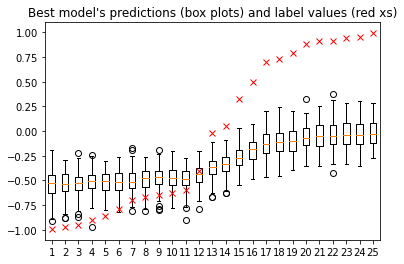

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

In [8]:
stats = Stats()
stats.update(bees, ex_ffss)
#stats.show_stats()
stats.show_best_model()
stats.get_plots()
stats.draw_frame()

### 6. Chimera Algorithm

This is the main loop of the program, where the Artificial Bee Colony Algorithm is used as the driver force for the Genetic Evolution of the models. The program will keep mutating the architectures until either the maximum number of iterations is reached or a model with a performance better than the set threshold is found.


Iteration 1 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

3 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


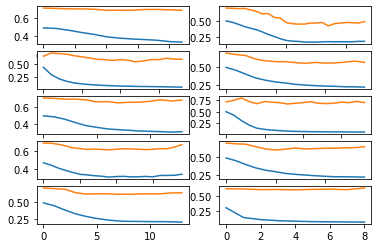

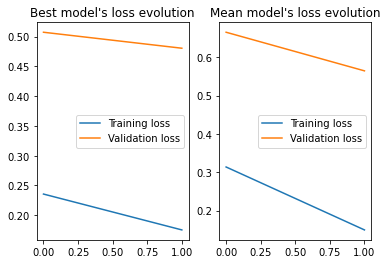

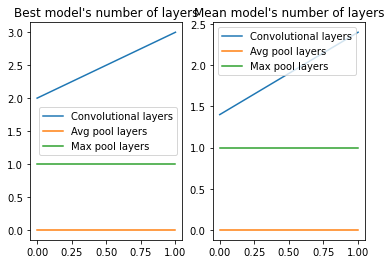

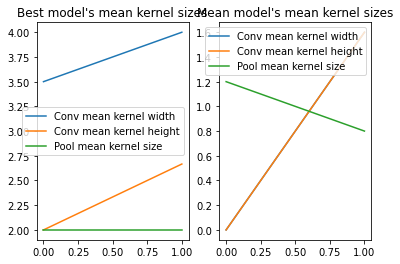

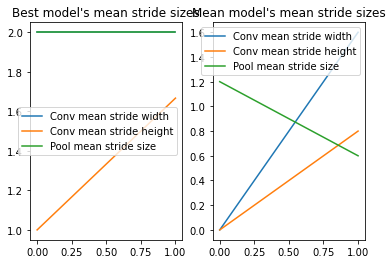

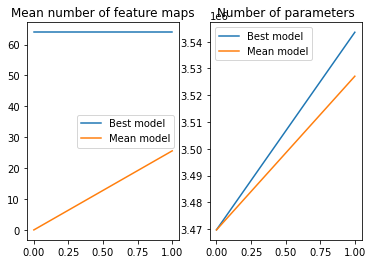

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(2, 5), stride=(1, 4), padding=(0, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 4), stride=(3, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


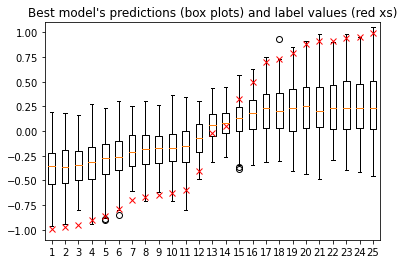

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 2 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

3 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


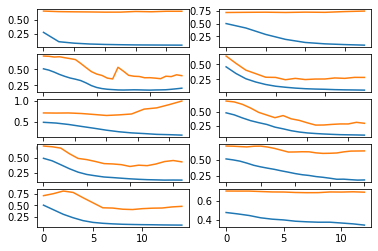

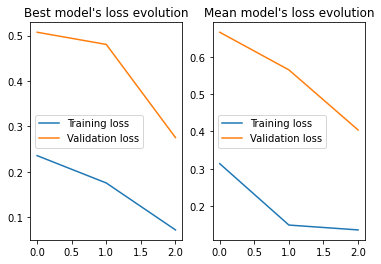

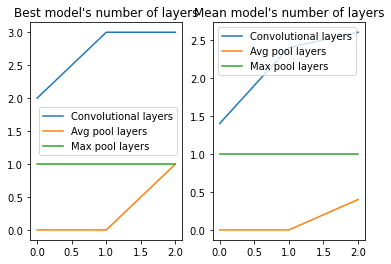

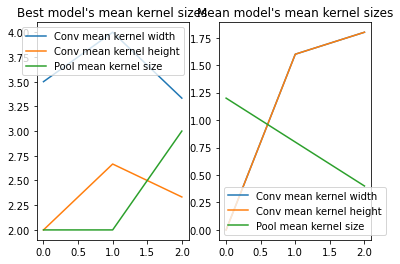

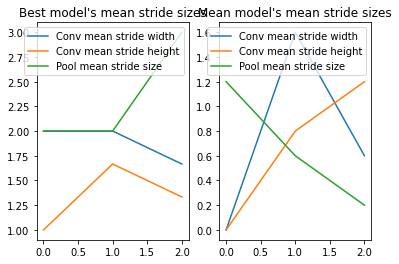

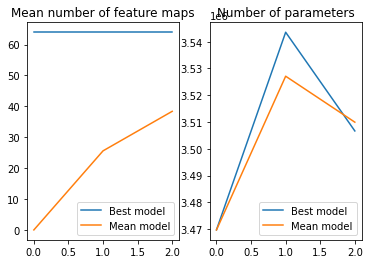

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


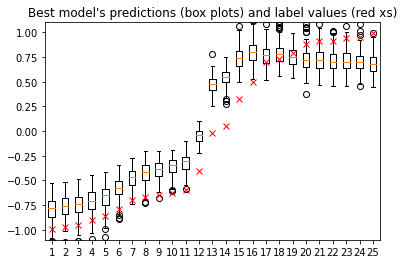

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 3 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


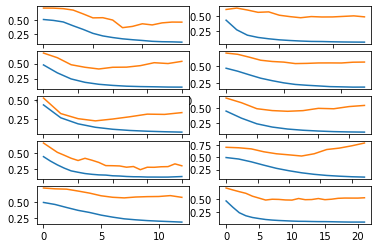

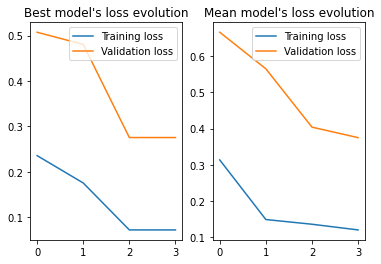

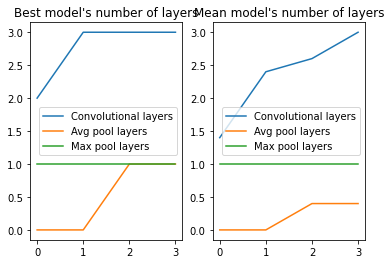

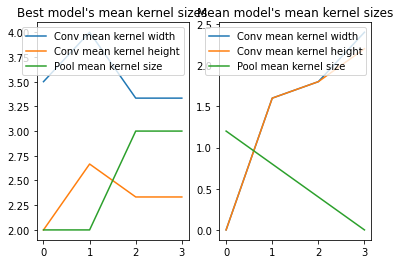

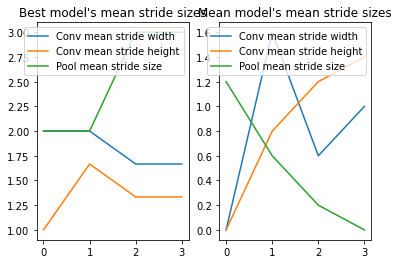

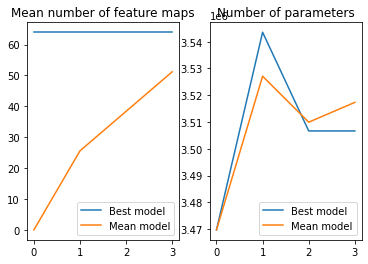

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


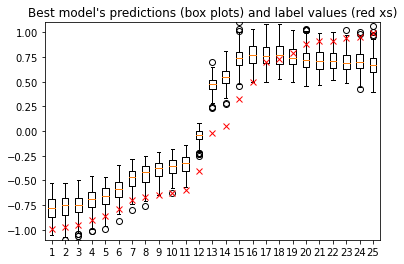

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 4 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


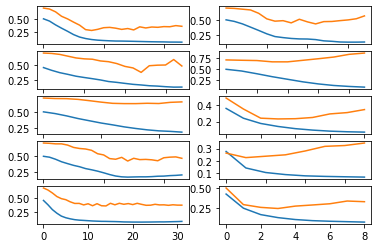

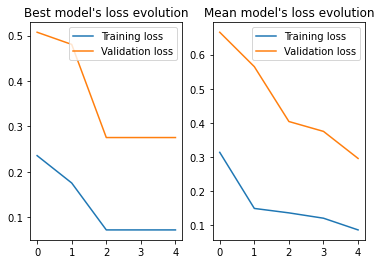

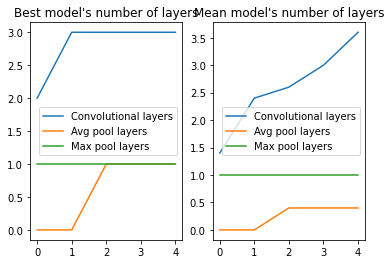

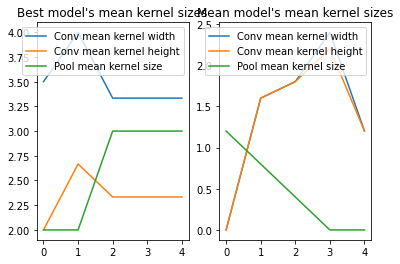

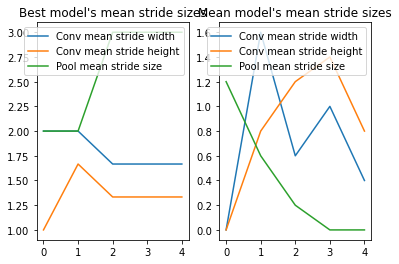

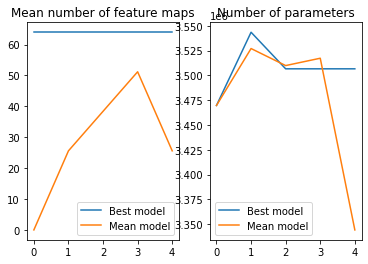

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


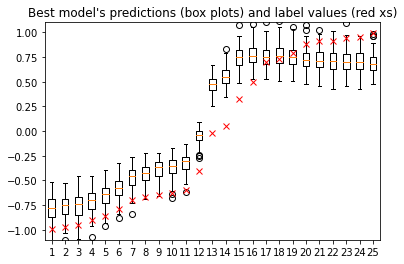

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 5 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


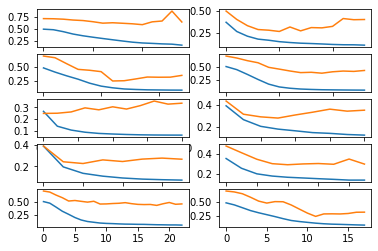

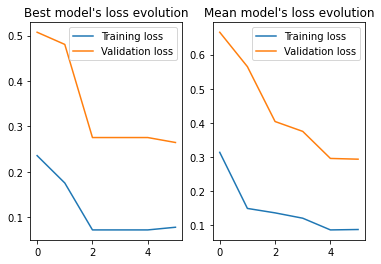

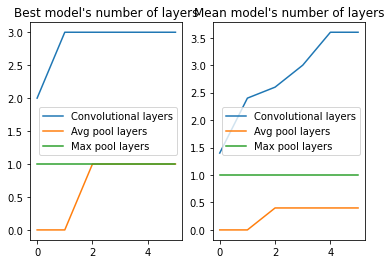

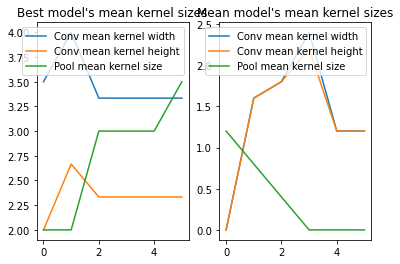

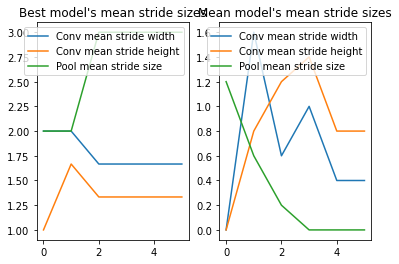

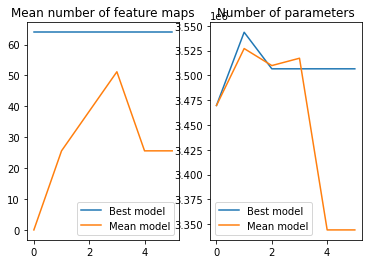

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


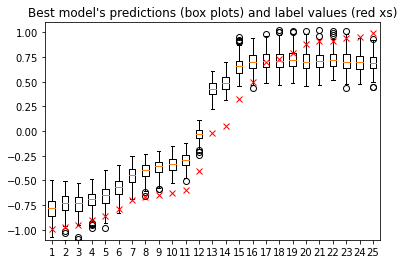

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 6 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


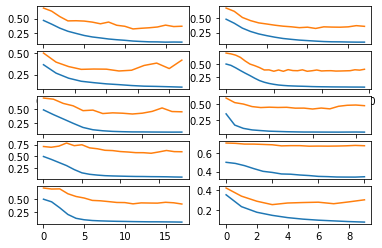

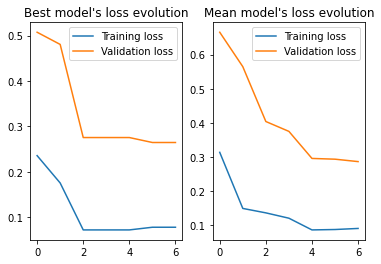

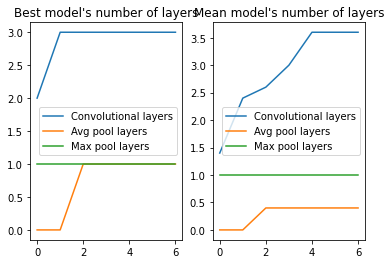

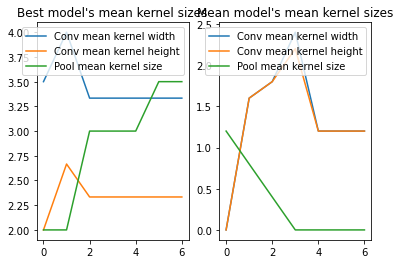

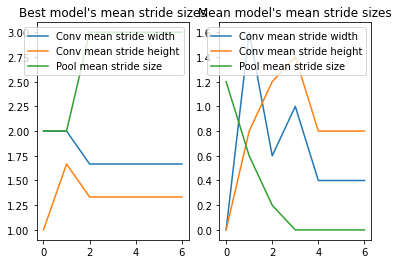

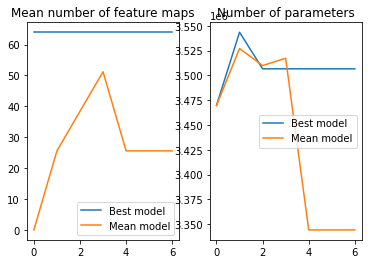

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


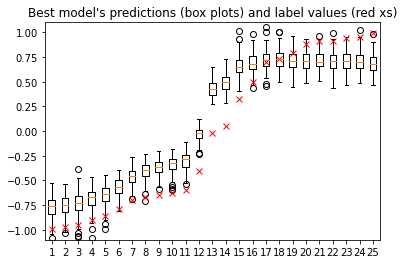

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 7 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


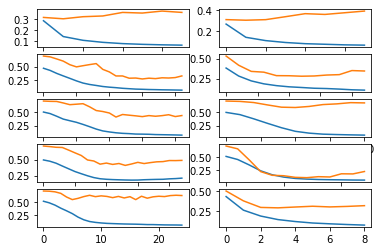

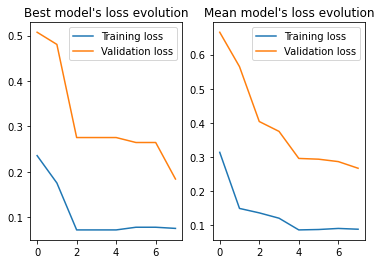

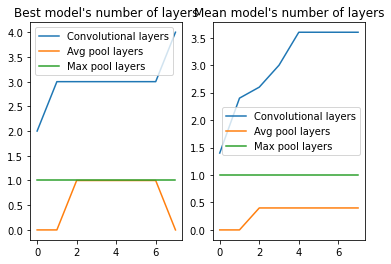

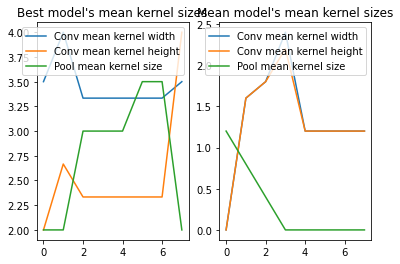

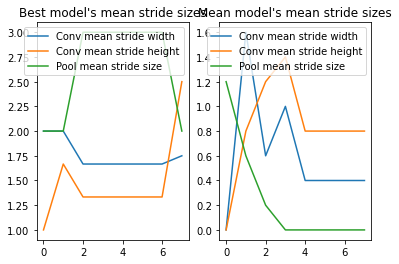

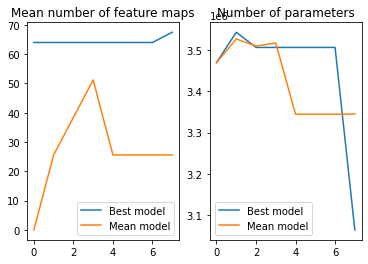

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 90, kernel_size=(5, 2), stride=(3, 2), padding=(1, 0))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(90, 64, kernel_size=(3, 4), stride=(3, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 52, kernel_size=(5, 5), stride=(3, 3), padding=(2, 1))
    (7): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=5200, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


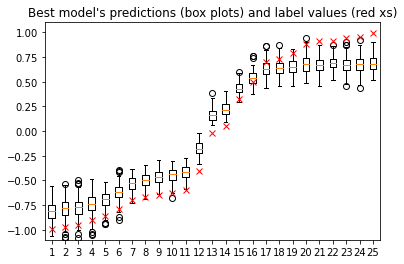

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 8 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


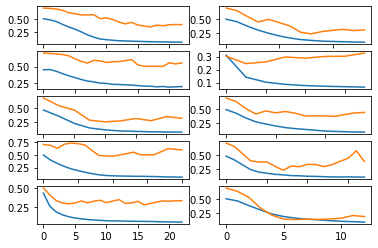

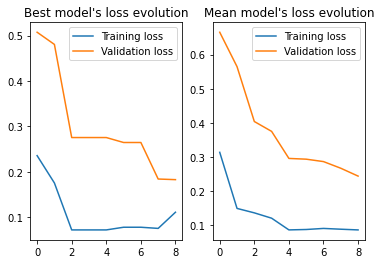

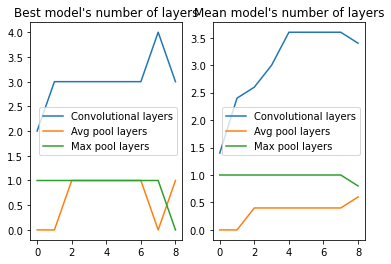

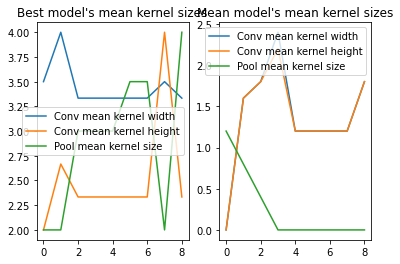

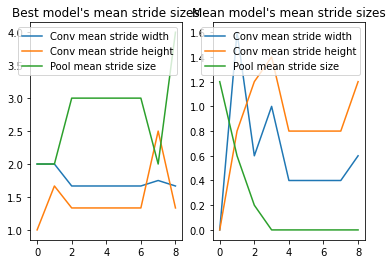

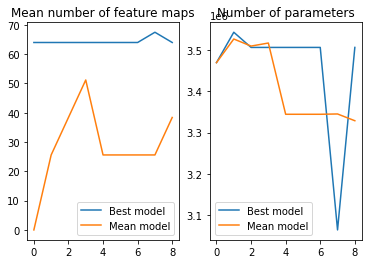

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


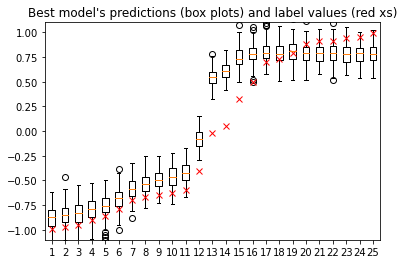

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 9 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


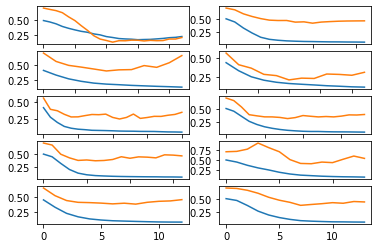

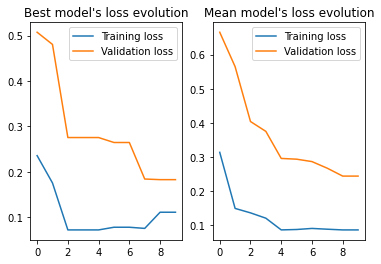

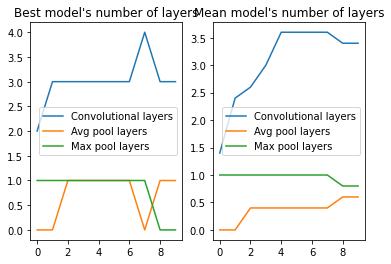

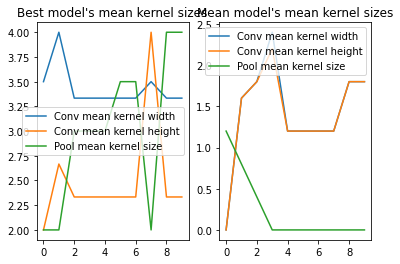

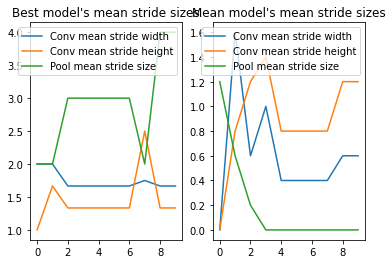

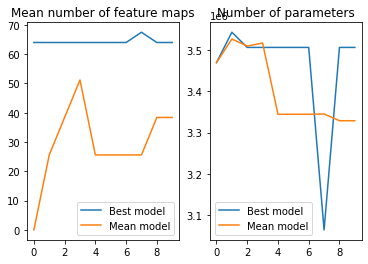

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


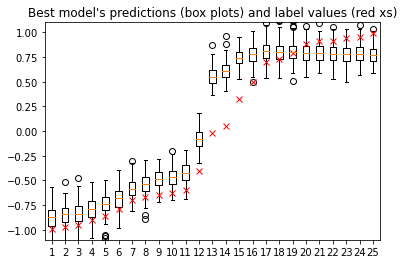

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 10 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 bees entered scouting mode


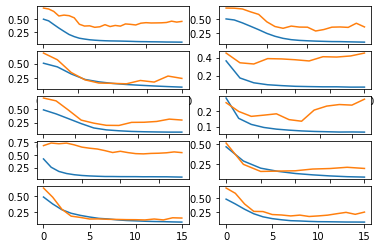

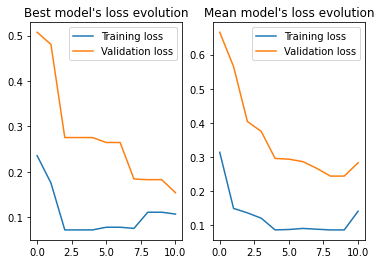

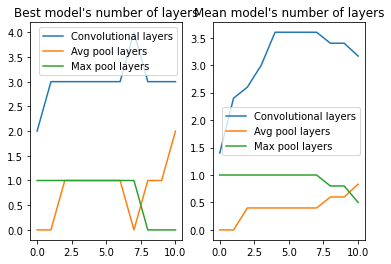

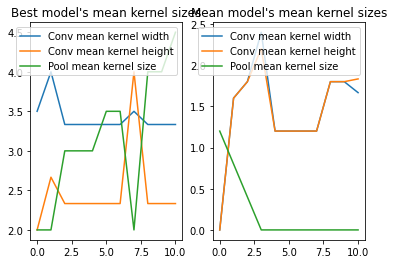

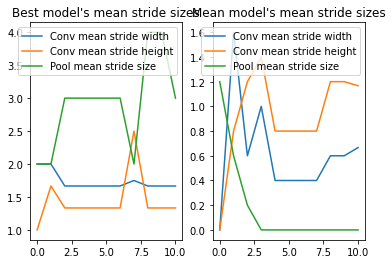

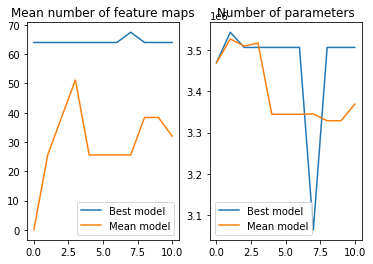

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): AvgPool2d(kernel_size=4, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


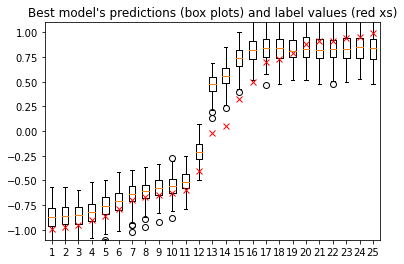

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 11 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


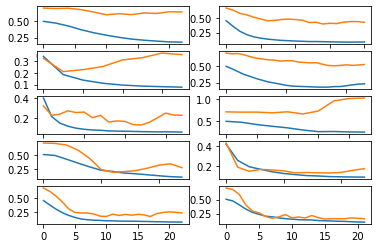

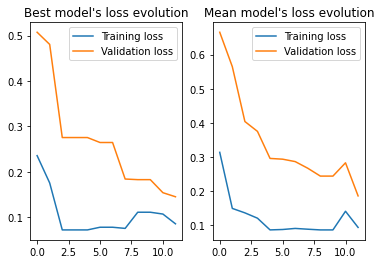

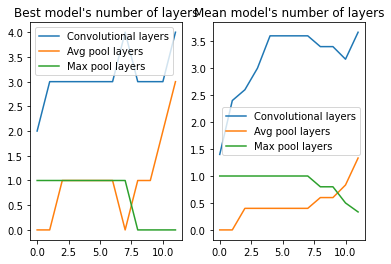

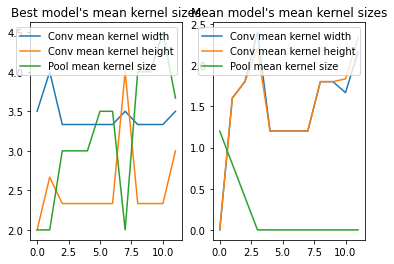

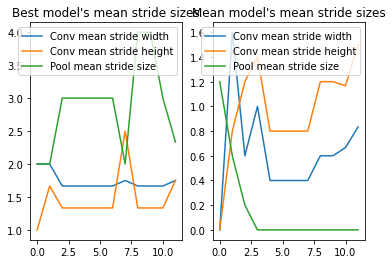

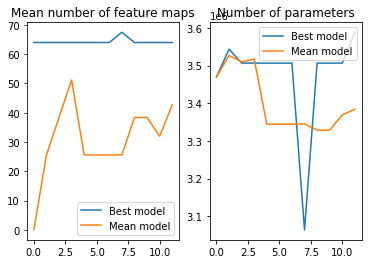

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): AvgPool2d(kernel_size=4, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(5, 4), stride=(3, 2), padding=(1, 2))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


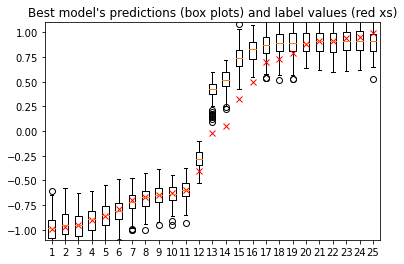

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 12 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

0 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


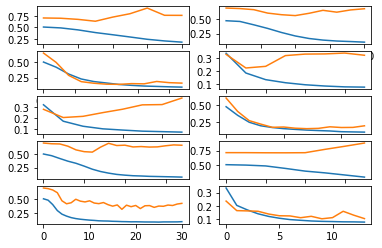

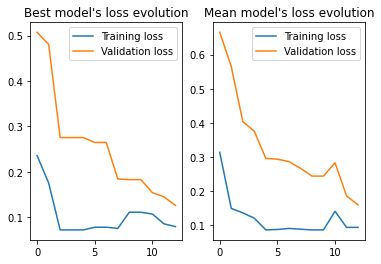

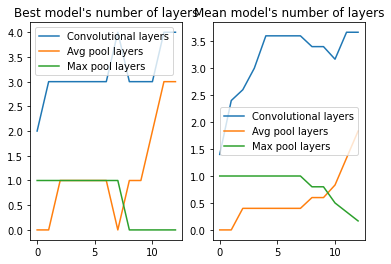

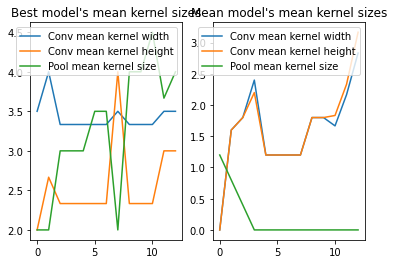

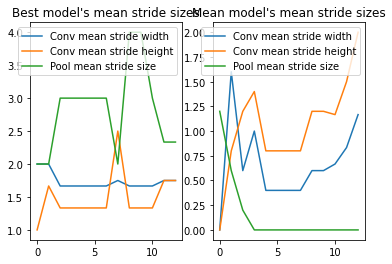

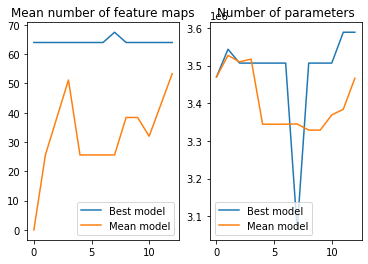

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): AvgPool2d(kernel_size=5, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(5, 4), stride=(3, 2), padding=(1, 2))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


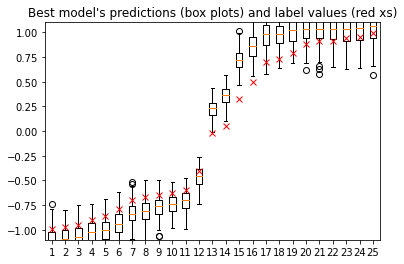

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]


Iteration 13 of the algorithm


Employed bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

1 better food sources found during employed bee phase


Onlooker bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1563 [00:00<?, ?it/s]

Checking current performance:   0%|          | 0/313 [00:00<?, ?it/s]

2 better food sources found during onlooker bee phase


Scouting bee phase:   0%|          | 0/5 [00:00<?, ?it/s]

No bees in scouting mode


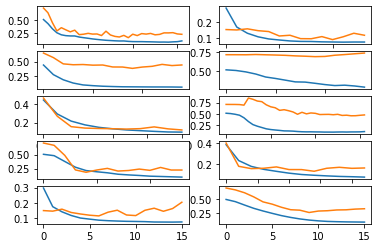

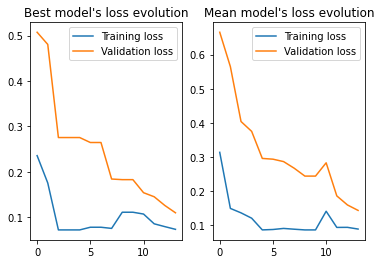

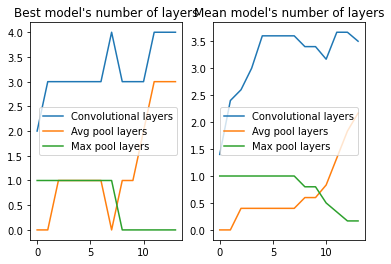

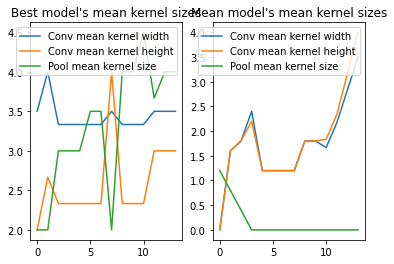

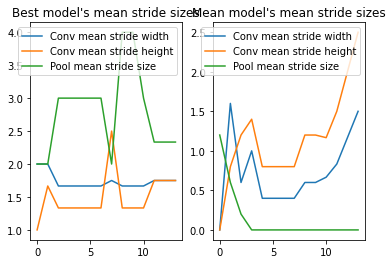

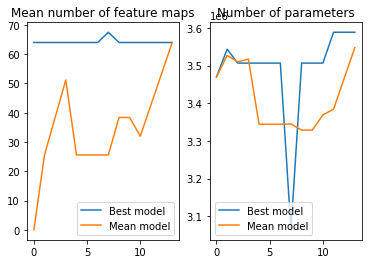

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=4, padding=0)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3), padding=(0, 1))
    (4): AvgPool2d(kernel_size=5, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 1), padding=(0, 1))
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(5, 4), stride=(3, 2), padding=(1, 2))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=[10, 10])
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Linear(in_features=6400, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
  )
)


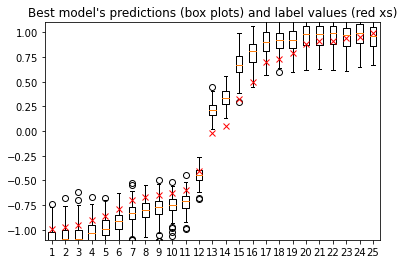

Obtaining the results on validation dataset:   0%|          | 0/4992 [00:00<?, ?it/s]

Good food source found in 14 iterations


In [9]:
max_iter = 30
perf_thresh = 0.15 # The tolerance for u-offset is 0.5mm

while current_iter < max_iter:
    current_iter += 1
    if stats.val_loss_evolution_best[-1] <= perf_thresh:
        print("Good food source found in", current_iter, "iterations")
        break
    print("")
    print("Iteration", current_iter, "of the algorithm")
    nectars = []
        
    #print("Employed Bee Phase")
    b = 0
    c = 0
    ffss = []
    with tqdm(total=Np, leave = False, desc = "Employed bee phase") as pbar:
        for bee in bees:    # Employed bee phase
            if bee.b_type == "employed":
                b += 1
                #print("    Employed Bee #" + str(b))
                c += bee.exploit_food_source()
                pbar.update(1)
                if bee.fs.fs_exhaustion >= bee.fs.fs_exhaustion_limit:
                    bee.scouting = True
                ffss += [bee.fs]
                nectars += [bee.fs.nectar]
    print(c, "better food sources found during employed bee phase")
    
    #print("Onlooking Bee Phase")
    b = 0
    c = 0
    with tqdm(total=Np, leave = False, desc = "Onlooker bee phase") as pbar:
        for bee in bees:  # Scouting bee phase
            if bee.b_type == "onlooker":
                b += 1
                #print("    Onlooker Bee #" + str(b))
                a, ffss, nectars= bee.scout_food_source(ffss, nectars)
                c += a
                pbar.update(1)
    print(c, "better food sources found during onlooker bee phase")
    
    #print("Scouting Bee Phase")
    a = 0
    b = 0
    with tqdm(total=Np, leave = False, desc = "Scouting bee phase") as pbar:
        for bee in bees:    # Scouting bee phase
            if bee.b_type == "employed":
                bee.fs = ffss[a]
                a += 1
                pbar.update(1)
                if bee.scouting:
                    b += 1
                    #print("    Scouting Bee #" + str(b)+ "reseted food source")
                    ex_ffss += [copy.deepcopy(bee.fs)]
                    invalid = True
                    while invalid:
                        base_fs = copy.deepcopy(original_fs)
                        base_fs.mutate_feature_extractor(15)
                        invalid = base_fs.train_fs()
                    bee.fs = copy.deepcopy(base_fs)
                    bee.scouting = False
    if b == 0:
        print("No bees in scouting mode")
    else:
        print(c, "bees entered scouting mode")
    
    # We then print the algorithm's current results
    plt.show()
    stats.update(bees, ex_ffss)
    stats.show_stats()
    stats.show_best_model()
    stats.get_plots()
    stats.draw_frame()
    stats.save_gif()

stats.save_gif()
if current_iter == max_iter:
    print("Algorithm unable to find suitable food source in", current_iter, "iterations.")

### 7. Save the Generated Models

The output models are saved in the specified folder, using their performance on the validation dataset as identifiers. Saving all the models allow for the further study of their performance as a population, and allow for further statistical testing to check whether the model with the best performance is, indeed, the best, most generalizable one

In [11]:
free_gpu_cache()

os.chdir("D:\\adri")
folder = "saved_models\\scratch\\180v3\\"
run_id = str(datetime.datetime.today())
for i in range(len(run_id)):
    if run_id[i] == "-" or run_id[i] == " " or run_id[i] == ":":
        run_id = run_id[:i]+"_"+run_id[i+1:]
    elif run_id[i] == ".":
        run_id = run_id[:i]
        break
model_save_path = folder+run_id
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)


models = [bee.fs for bee in bees[:Np]] + ex_ffss
for i in range(len(models)):
    model = copy.deepcopy(models[i])
    torch.save(model.food, model_save_path+"\\"+str(np.mean(model.val_loss_ev[-4:]))+".pt")

del model

### 8. Visualize the results

A new missaligned reconstruction is created and the given model is tested on it. The original (unartifacted), the artifacted and the corrected images are saved for further comparison in external programs. Most of this part is hard-coded, like the FUX-Sim path and the filenames.

Some of the functions developed on the first sections are defined again as to be able to separate these sections and analyze models without the need for running the rest of the code.

In [134]:
os.chdir("D:\\adri")

proj_call = "simulator\\cmake\\build\\Debug\\fux-sim_1_0_5.exe -fi D:\\adri\\matlab_preproc\\RATA_2_ICTUS_516x516x574.img -fo D:\\adri\\Validation\\Proj\\Rat_miss_proj.ctf -m 1 0 0 -a 360 -c 0.121849 0.121849 0.121849 -ip 0.2 0.2 -k 2 -# 2 -do 144.95188 -t -1 -so 226 -b 516 516 574 -d 516 574"
du = "-0.1"
roll = "0"
ssd = "0"
proj_call += " -u " + du + " 0 0 " + roll + " " + ssd
os.system(proj_call)

recocall = "simulator\\cmake\\build\\Debug\\fux-sim_1_0_5.exe -fi D:\\adri\\Validation\\Proj\\Rat_miss_proj_516x574x360.ctf -fo D:\\adri\\Validation\\Reco_artifact\\Reco_no_correction.img -m 0 0 0 -a 180 -sp 180 -o 0 0 0 -c 0.121849 0.121849 0.121849 -ip 0.2 0.2 -k 2 -# 2 -so 226 -do 144.95188 -t -1 -vw 1 0.001 -ft 1 -r 516 516 574 -d 516 574"
os.system(recocall)

os.remove("Validation\\Reco_artifact\\log_file.log")
os.remove("Validation\\Reco_artifact\\progress_ct.list")
os.remove("Validation\\Reco_artifact\\Reco_no_correction_516x516x574_parameters.txt")
os.rename("Validation\\Reco_artifact\\Reco_no_correction_516x516x574.img", "Validation\\Reco_artifact\\Reco_no_correction_516x516x574_" + du + "mm_du_" + roll + "deg_roll_" + ssd + "mm_sdd.img")

In [135]:
class VolDset(Dataset):
    def __init__(self, path, view, transform):
        #Copy attributes of the function into self variable
        self.path_inp = path
        self.inp = os.listdir(self.path_inp)
        self.n_slices=0
        self.view=view
        self.transform=transform
        self.path=path

    def __getitem__(self, idx):
        pat=r'\d+x\d+x\d+'
        self.vol_inp = self.inp[idx]
        self.size = re.findall(pat,str(self.vol_inp))
        self.size = self.size[0].split("x")
        self.size = [int(i) for i in self.size]
        
        self.vol_inp = open(str(self.path_inp)+'\\'+self.vol_inp,'rb') #only opens the file for reading
        self.vol_inp = np.fromfile(self.vol_inp,dtype='<f4')
        self.vol_inp = self.vol_inp.reshape(self.size[0], self.size[1], self.size[2], order='F')
        
        self.param_out = self.inp[idx]
        # pat=r'-*\d+\.\d+deg_roll+'
        pat=r'-*\d+\.\d+mm_du+'
        self.param_out = re.findall(pat,str(self.param_out))
        self.param_out = float(self.param_out[0][:-5]) # 8
        
        if self.transform:
            if self.view=='axial':
                self.list_img_inp = [self.transform(self.vol_inp[:,:,i]) for i in range(self.size[2])]
            elif self.view=='coronal':
                self.list_img_inp = [self.transform(self.vol_inp[:,i,:]) for i in range(self.size[1])]
        
        return self.list_img_inp, self.param_out
    
    def __len__(self):            
        return len(self.inp)


path_data = Path(r"Validation\Reco_artifact")

view='axial'
if view=='coronal':
    size=(512,512)#512x274
elif view=='axial':
    size=(512,512)#512x350
    
data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        transforms.Grayscale(num_output_channels=3), # transforms.RandomHorizontalFlip(), transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.225])])

image_datasets_unsqueeze = VolDset(path_data,view,data_transforms)
dataset_sizes = len(image_datasets_unsqueeze)

Dataset succesfully converted
Image size = torch.Size([3, 256, 256])

Example image shown below:


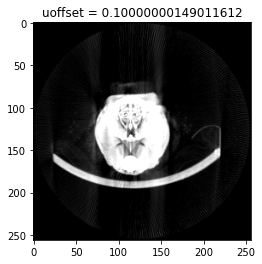

In [136]:
x=[]
y=[]
for i in range(dataset_sizes):
    inp,lbl=image_datasets_unsqueeze[i]
    for j in range(100, 500):
        x.append(inp[j])
        y.append(abs(lbl)) # abs(lbl)
print("Dataset succesfully converted")
dset=list(zip(x,torch.Tensor(y).float()))

x,y=dset[100]
input_size = x.data.size()
print("Image size =", input_size)
print("")
print("Example image shown below:")
plt.imshow(x.data[1,:,:].T, cmap='gray')
plt.title('uoffset = ' + str(y.item()))

# Lastly we create the DataLoaders from the DataSets specifying batch_size and shuffle
loader = DataLoader(dset, batch_size=16, shuffle=False) #, **kwargs)

# We now get rid of the variables we will not be using anymore
del inp, lbl, image_datasets_unsqueeze, x, y

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model = torch.hub.load('pytorch/vision:v0.10.0', "vgg11", pretrained=True) # torch.load(model_save_path)
#model.classifier = nn.Sequential(*list(model.classifier.children()), nn.ReLU(), nn.Linear(1000, 1))

model = torch.load("saved_models\\transfer\\180\\2022_04_19_22_50_24\\0.0668844834093552.pt")

model.to(device)
results = torch.empty(0)
with tqdm(total=len(loader), leave = False, desc = "Obtaining the results for the new volume") as pbar:
    with torch.no_grad():
        for data in loader:
            features, labels = data
            features = features.to(device)
            vi = model(features).squeeze().to("cpu")
            results = torch.cat((results, vi), 0)
            pbar.update(labels.size(0))

Obtaining the results for the new volume:   0%|          | 0/25 [00:00<?, ?it/s]

In [139]:
corr_recocall = "simulator\\cmake\\build\\Debug\\fux-sim_1_0_5.exe -fi D:\\adri\\Validation\\Proj\\Rat_miss_proj_516x574x360.ctf -fo D:\\adri\\Validation\\Reco_corrected\\Reco_artifacted.img -m 0 0 0 -a 360 -o 0 0 0 -c 0.121849 0.121849 0.121849 -ip 0.2 0.2 -k 2 -# 2 -so 226 -do 144.95188 -t -1 -vw 1 0.001 -ft 1 -r 516 516 574 -d 516 574"
os.system(corr_recocall)

corr_recocall = "simulator\\cmake\\build\\Debug\\fux-sim_1_0_5.exe -fi D:\\adri\\Validation\\Proj\\Rat_miss_proj_516x574x360.ctf -fo D:\\adri\\Validation\\Reco_corrected\\Reco_corrected.img -m 0 0 0 -a 360 -o 0 0 0 -c 0.121849 0.121849 0.121849 -ip 0.2 0.2 -k 2 -# 2 -so 226 -do 144.95188 -t -1 -vw 1 0.001 -ft 1 -r 516 516 574 -d 516 574"
corr_recocall += " -u " + str(np.median(results)) + " 0 0 0 0"
os.system(corr_recocall)

os.remove("Validation\\Reco_corrected\\log_file.log")
os.remove("Validation\\Reco_corrected\\progress_ct.list")
os.remove("Validation\\Reco_corrected\\Reco_artifacted_516x516x574_parameters.txt")
os.remove("Validation\\Reco_corrected\\Reco_corrected_516x516x574_parameters.txt")